# Exploratory Data Analysis

First, I want to check, if the naming of the files is coherent.

In [29]:
import os
import re

data_folder = "Data"

# Define the regex pattern for matching the filenames
pattern = re.compile(r'^OAS1_(\d{4})_MR(\d+)_mpr-(\d{1})_(\d{3})\.jpg$')

# Function to check if a filename matches the pattern
def is_valid_filename(filename):
    return bool(pattern.match(filename))

# Function to iterate through all files and folders and check filenames
def check_file_structure(root_folder):
    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not is_valid_filename(file):
                print(f"Invalid filename found: {file} in directory: {subdir}")
                return False
    return True

# Check the file structure
if check_file_structure(data_folder):
    print("All filenames follow the correct structure.")
else:
    print("Some filenames do not follow the correct structure.")


Invalid filename found: .DS_Store in directory: Data
Some filenames do not follow the correct structure.


Now, I want to check, if the images, have the same sizes and if there slices are the same for each session.

In [30]:
import os
from collections import defaultdict
from PIL import Image

# Dictionary to store image paths
image_paths = {
    "Non Demented": [],
    "Very mild Dementia": [],
    "Mild Dementia": [],
    "Moderate Dementia": []
}

# Traverse through the folder structure
for root, dirs, files in os.walk(data_folder):
    for file in files:
        if file.endswith(".jpg"):
            # Extract dementia level from folder name
            dementia_level = os.path.basename(root)
            # Extract subject ID from file name
            subject_id = file.split("_")[0]
            # Extract image slice number
            slice_number = int(file.split("_")[-1].split(".")[0])
            # Add image path to the corresponding dementia level
            image_paths[dementia_level].append(os.path.join(root, file))


def check_image_formats(image_paths):
    """Check if all images have the same format and size."""
    formats = set()
    sizes = set()
    for paths in image_paths.values():
        for path in paths:
            # Get image format
            format_info = path.split(".")[-1]
            formats.add(format_info)
            
            # Get image size
            with Image.open(path) as img:
                img_size = img.size
                sizes.add(img_size)
    
    # Print different formats
    print("Different image formats:")
    for fmt in formats:
        print(fmt)
    
    # Print different sizes
    print("\nDifferent image sizes:")
    for size in sizes:
        print(size)
    
    return len(formats) == 1, len(sizes) == 1


check_image_formats(image_paths)


Different image formats:
jpg

Different image sizes:
(496, 248)


(True, True)

In [31]:
import pandas as pd

# Function to extract information from filename
def extract_info_from_filename(filename):
    match = pattern.match(filename)
    subject_id = match.group(1)
    session = match.group(2)
    mpr = match.group(3)
    slice_number = int(match.group(4))
    return subject_id, session, mpr, slice_number

# Function to create DataFrame
def create_dataframe(root_folder):
    data = []
    for subdir, _, files in os.walk(root_folder):
        class_name = os.path.basename(subdir)
        for file in files:
            if is_valid_filename(file):
                subject_id, session, mpr, slice_number = extract_info_from_filename(file)
                path = os.path.join(subdir, file)
                data.append((class_name, subject_id, session, mpr, slice_number, path))
    df = pd.DataFrame(data, columns=['class', 'subject_ID', 'session', 'mpr', 'slice', 'path'])
    return df

# Create the DataFrame
df = create_dataframe(data_folder)
df.sort_values(by=['class', 'subject_ID', 'session', 'mpr', 'slice'], inplace=True)


# Display the DataFrame
print(df.head())

# df.to_csv('Data/alzheimer_data.csv', index=False)  # Saves the DataFrame to a CSV file without including the index



              class subject_ID session mpr  slice  \
916   Mild Dementia       0028       1   1    100   
1140  Mild Dementia       0028       1   1    101   
836   Mild Dementia       0028       1   1    102   
630   Mild Dementia       0028       1   1    103   
278   Mild Dementia       0028       1   1    104   

                                                path  
916   Data/Mild Dementia/OAS1_0028_MR1_mpr-1_100.jpg  
1140  Data/Mild Dementia/OAS1_0028_MR1_mpr-1_101.jpg  
836   Data/Mild Dementia/OAS1_0028_MR1_mpr-1_102.jpg  
630   Data/Mild Dementia/OAS1_0028_MR1_mpr-1_103.jpg  
278   Data/Mild Dementia/OAS1_0028_MR1_mpr-1_104.jpg  


In [32]:
# Function to check for missing slices within each session
def check_missing_slices(df):
    missing_slices = []
    for _, group in df.groupby(['subject_ID', 'session']):
        slices_present = set(group['slice'])
        missing = set(range(100, 161)) - slices_present
        if missing:
            missing_slices.append((group.iloc[0]['subject_ID'], group.iloc[0]['session'], missing))
    return missing_slices

# Check for missing slices
missing_slices = check_missing_slices(df)

# Print any missing slices
if missing_slices:
    print("Missing slices:")
    for subject_id, session, missing in missing_slices:
        print(f"Subject ID: {subject_id}, Session: {session}, Missing slices: {missing}")
else:
    print("All slices from 100 to 160 are present for each session.")


All slices from 100 to 160 are present for each session.


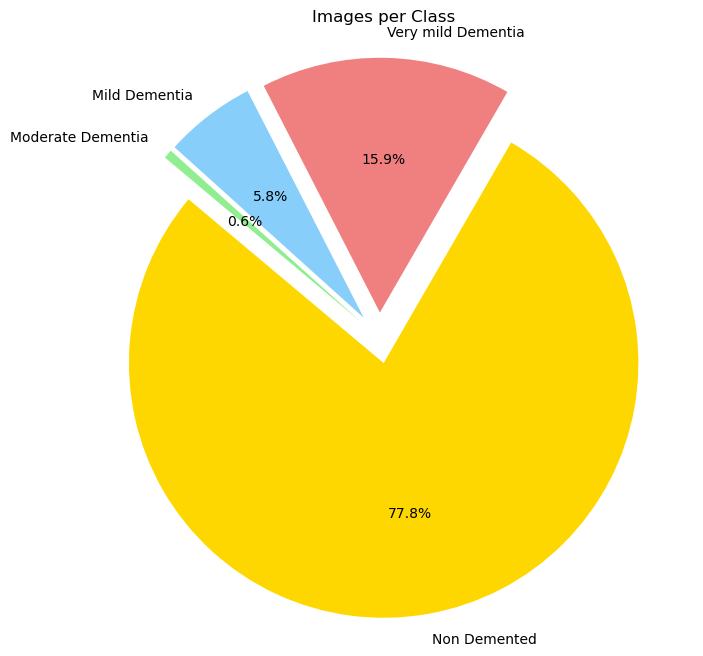

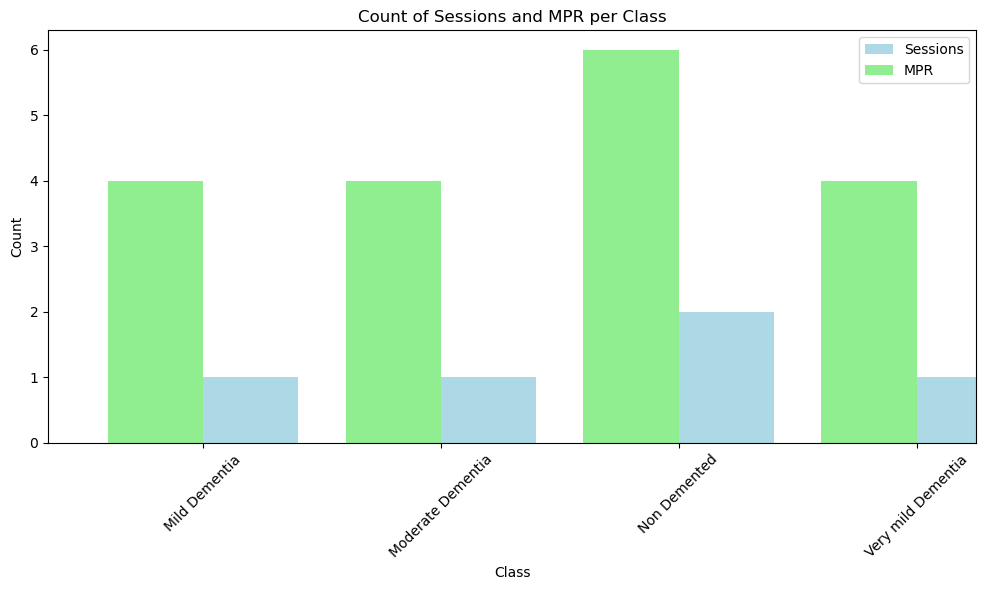

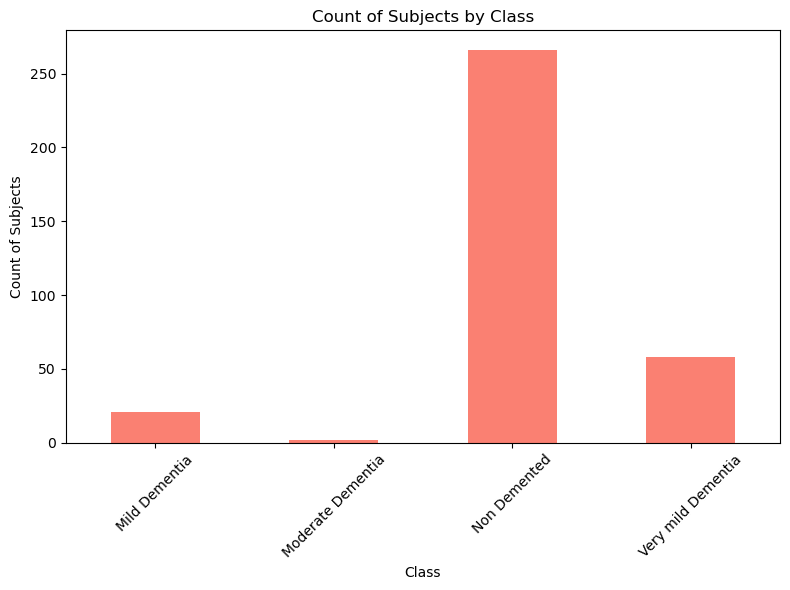

In [27]:
import matplotlib.pyplot as plt

# 1. Pie chart of Images per Class
plt.figure(figsize=(8, 8))
class_counts = df['class'].value_counts()
explode = [0.1] * len(class_counts)
colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen']
plt.pie(class_counts, labels=class_counts.index, explode=explode, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Images per Class')
plt.axis('equal')
plt.show()

# Count of Sessions and MPR per Class
session_counts = df.groupby('class')['session'].nunique()
mpr_counts = df.groupby('class')['mpr'].nunique()

# Plotting
plt.figure(figsize=(10, 6))
session_counts.plot(kind='bar', color='lightblue', position=0, width=0.4, label='Sessions')
mpr_counts.plot(kind='bar', color='lightgreen', position=1, width=0.4, label='MPR')
plt.title('Count of Sessions and MPR per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# 4. Check if there are subjects in multiple classes
subjects_multiple_classes = df.groupby('subject_ID')['class'].nunique()
subjects_multiple_classes = subjects_multiple_classes[subjects_multiple_classes > 1]
if not subjects_multiple_classes.empty:
    print("Subjects in multiple classes:")
    print(subjects_multiple_classes)
    # Add the count of subjects in multiple classes to the count of subjects by class plot
    for subject_id, num_classes in subjects_multiple_classes.items():
        df.loc[df['subject_ID'] == subject_id, 'class'] = 'Multiple Classes'
    plt.figure(figsize=(8, 6))
    df.groupby('class')['subject_ID'].nunique().plot(kind='bar', color='salmon')
    plt.title('Count of Subjects by Class')
    plt.xlabel('Class')
    plt.ylabel('Count of Subjects')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(8, 6))
    df.groupby('class')['subject_ID'].nunique().plot(kind='bar', color='salmon')
    plt.title('Count of Subjects by Class')
    plt.xlabel('Class')
    plt.ylabel('Count of Subjects')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [28]:
print(df.groupby('class')['session'].unique())
print(df.groupby('class')['mpr'].unique())


class
Mild Dementia            [1]
Moderate Dementia        [1]
Non Demented          [1, 2]
Very mild Dementia       [1]
Name: session, dtype: object
class
Mild Dementia               [1, 2, 3, 4]
Moderate Dementia           [1, 2, 3, 4]
Non Demented          [1, 2, 3, 4, 5, 6]
Very mild Dementia          [1, 2, 3, 4]
Name: mpr, dtype: object
